In [1]:
# First cell - Imports and Setup
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
# Second cell - UNet Model Definition
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv1 = DoubleConv(1, 32)
        self.conv2 = DoubleConv(32, 64)
        self.conv3 = DoubleConv(64, 128)
        
        # Decoder
        self.up_conv2 = DoubleConv(192, 64)
        self.up_conv1 = DoubleConv(96, 32)
        
        # Final convolution
        self.final_conv = nn.Conv2d(32, 3, kernel_size=1)
        
        # Pooling and upsampling
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        x = self.pool(conv1)
        
        conv2 = self.conv2(x)
        x = self.pool(conv2)
        
        # Bridge
        x = self.conv3(x)
        
        # Decoder
        x = self.up(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.up_conv2(x)
        
        x = self.up(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.up_conv1(x)
        
        x = self.final_conv(x)
        return x


In [3]:
# Third cell - Dataset Class
class DemosaicingDataset(Dataset):
    def __init__(self, root_dir, split_file, patch_size=32):
        self.root_dir = root_dir
        self.groundtruth_dir = os.path.join(root_dir, 'groundtruth')
        self.input_dir = os.path.join(root_dir, 'input')
        self.patch_size = patch_size
        
        with open(split_file, 'r') as f:
            self.image_files = [line.strip() + '.png' for line in f.readlines()]
            
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        
        # Load input image (raw Bayer)
        input_path = os.path.join(self.input_dir, img_file)
        input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
        input_img = input_img.astype(np.float32) / 65535.0
        
        # Load ground truth
        gt_path = os.path.join(self.groundtruth_dir, img_file)
        gt_img = cv2.imread(gt_path)
        gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
        gt_img = gt_img.astype(np.float32) / 255.0
        
        # Convert to tensors
        input_tensor = torch.from_numpy(input_img).float().unsqueeze(0)
        target_tensor = torch.from_numpy(gt_img).float().permute(2, 0, 1)
        
        return {
            'input': input_tensor,
            'target': target_tensor,
            'image_file': img_file
        }



In [4]:
# Fourth cell - Evaluation Functions
def calculate_psnr(img1, img2, max_value=1.0):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(max_value / np.sqrt(mse))

def evaluate_test_set(model_path, test_loader, device):
    # Load model
    checkpoint = torch.load(model_path)
    model = UNet().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    metrics = {
        'psnr_total': [],
        'cpsnr': [],
        'psnr_r': [],
        'psnr_g': [],
        'psnr_b': [],
        'filenames': []
    }
    
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            filenames = batch['image_file']
            
            outputs = model(inputs)
            
            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()
            
            for i in range(outputs.shape[0]):
                output_img = np.transpose(outputs[i], (1, 2, 0))
                target_img = np.transpose(targets[i], (1, 2, 0))
                
                # Overall PSNR
                psnr = calculate_psnr(target_img, output_img)
                metrics['psnr_total'].append(psnr)
                metrics['filenames'].append(filenames[i])
                
                # Per-channel PSNR
                psnr_r = calculate_psnr(target_img[..., 0], output_img[..., 0])
                psnr_g = calculate_psnr(target_img[..., 1], output_img[..., 1])
                psnr_b = calculate_psnr(target_img[..., 2], output_img[..., 2])
                
                metrics['psnr_r'].append(psnr_r)
                metrics['psnr_g'].append(psnr_g)
                metrics['psnr_b'].append(psnr_b)
                
                # CPSNR
                cpsnr = np.mean([psnr_r, psnr_g, psnr_b])
                metrics['cpsnr'].append(cpsnr)
    
    return metrics

In [5]:
# Fifth cell - Prepare Dataset and Run Evaluation
dataset_path = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic'
test_split = os.path.join(dataset_path, 'test.txt')

# Create test dataset and dataloader
test_dataset = DemosaicingDataset(
    root_dir=dataset_path,
    split_file=test_split,
    patch_size=32
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Run evaluation
metrics = evaluate_test_set('best_unet_model.pth', test_loader, device)



/tmp/ipykernel_2449378/3871240744.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [6]:
# Sixth cell - Display Results
print("\nTest Set Evaluation Results:")
print("-" * 50)
print(f"Average PSNR: {np.mean(metrics['psnr_total']):.2f} dB")
print(f"Average CPSNR: {np.mean(metrics['cpsnr']):.2f} dB")
print("\nPer-channel PSNR:")
print(f"R: {np.mean(metrics['psnr_r']):.2f} dB")
print(f"G: {np.mean(metrics['psnr_g']):.2f} dB")
print(f"B: {np.mean(metrics['psnr_b']):.2f} dB")






Test Set Evaluation Results:
--------------------------------------------------
Average PSNR: 38.29 dB
Average CPSNR: 38.82 dB

Per-channel PSNR:
R: 36.97 dB
G: 41.56 dB
B: 37.93 dB


/tmp/ipykernel_2449378/2896465498.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_unet_model.pth')


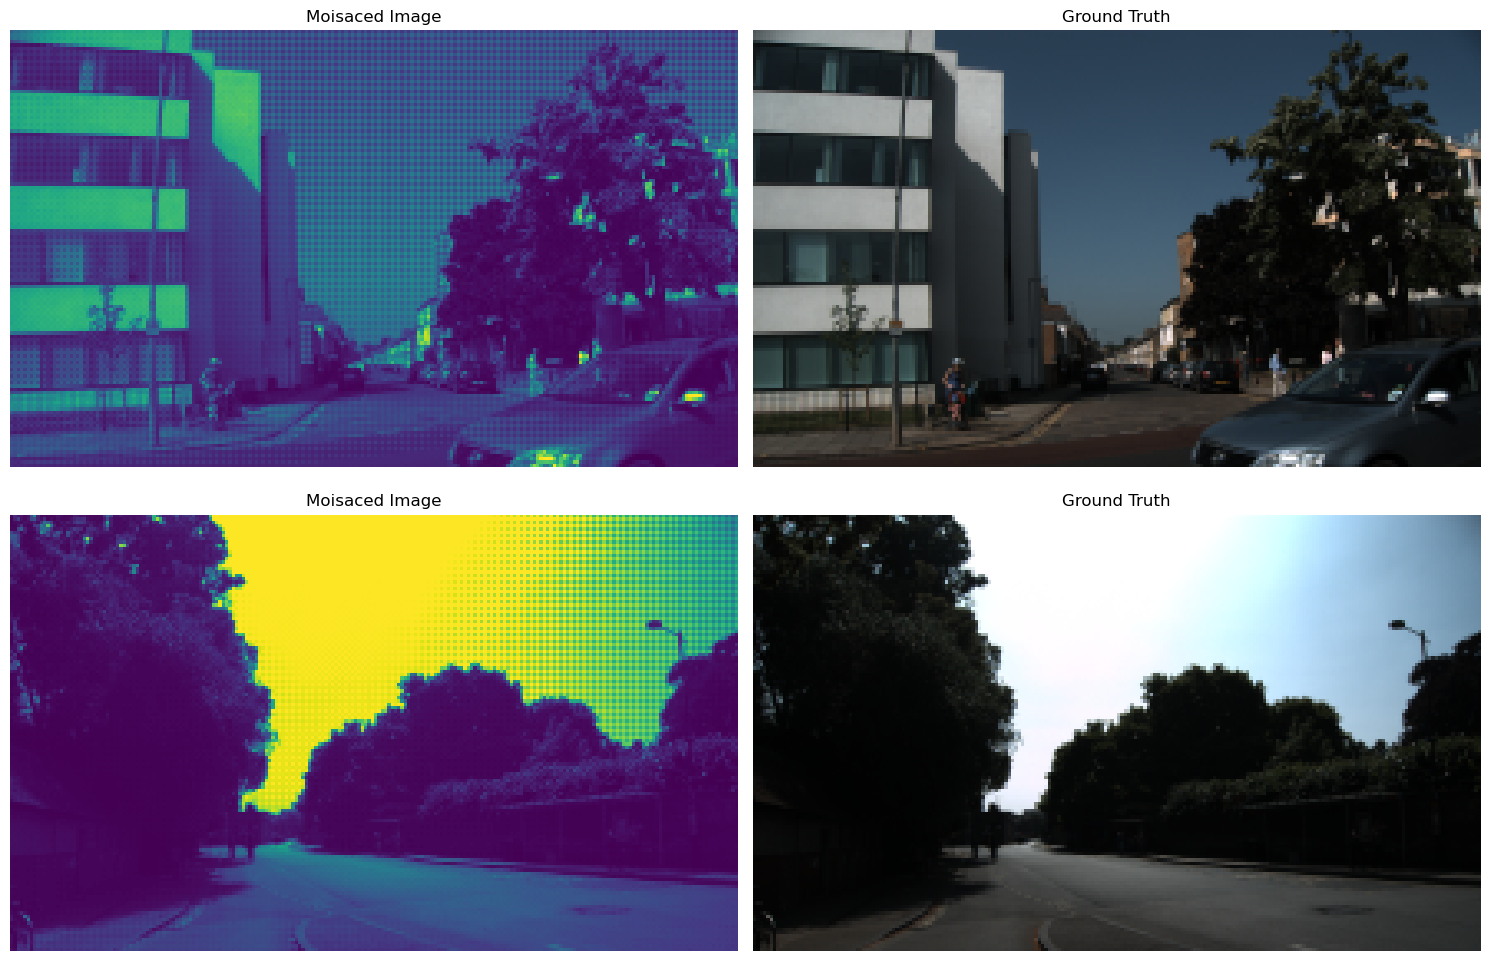

In [17]:
def visualize_test_results(model, test_loader, device, num_samples= 2):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))    
    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            if idx >= num_samples:
                break
                
            inputs = batch['input'].to(device)
            targets = batch['target']
            filename = batch['image_file'][0]
            
            # Get model prediction
            output = model(inputs)
            output = output.cpu()
            
            # Convert tensors to displayable images
            input_img = inputs[0, 0].cpu().numpy()
            target_img = targets[0].permute(1, 2, 0).numpy()
            output_img = output[0].permute(1, 2, 0).numpy()
            
            # Plot
            axes[idx, 0].imshow(input_img)
            axes[idx, 0].set_title(f'Moisaced Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(np.clip(target_img, 0, 1))
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')
            
          
            
    plt.tight_layout()
    plt.show()

# Load model and visualize
checkpoint = torch.load('best_unet_model.pth')
model = UNet().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
visualize_test_results(model, test_loader, device)